<a href="https://colab.research.google.com/github/EGEG1212/TIL_AudioSpeechProcessing/blob/main/5_%EC%9D%8C%EC%84%B1%ED%95%A9%EC%84%B1Speech_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음성합성(Speech Sunthesis)
- <https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2>

## Tacotron2
- 텍스트에서 멜 스펙트로그램 생성
- <https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/>

## WaveGlow
- 멜 스펙트로그램에서 음성 생성 (더 좋은 성능을 위해) 
- <https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/>

In [1]:
!pip install numpy scipy librosa unidecode inflect

     |████████████████████████████████| 245kB 5.8MB/s 


- LJ Speech dataset에서 사전 학습된 Tacotron2와 WaveGlow 모델 로드

In [2]:
import torch

tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')

Downloading: "https://github.com/nvidia/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [3]:
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [4]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

## Text To Speech(TTS)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

def plot_data(data, figsize=(16, 4)):
  fig, axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
    axes[i].imshow(data[i], aspect='auto', origin='bottom',
                   interpolation='none', cmap='viridis')

def TTS(text):
  sampling_rate = 22050

  sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
  sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)

  with torch.no_grad():
    mel_outputs, mel_outputs_postnet, _, aligments = tacotron2.infer(sequence)
    audio = waveglow.infer(mel_outputs_postnet)

  mel_output = mel_outputs.data.cpu().numpy()[0]
  mel_output_postnet = mel_outputs_postnet.data.cpu().numpy()[0]
  aligment = aligments.data.cpu().numpy()[0].T
  audio_np = audio[0].data.cpu().numpy()

  return mel_output, mel_output_postnet, aligment, audio_np, sampling_rate
    

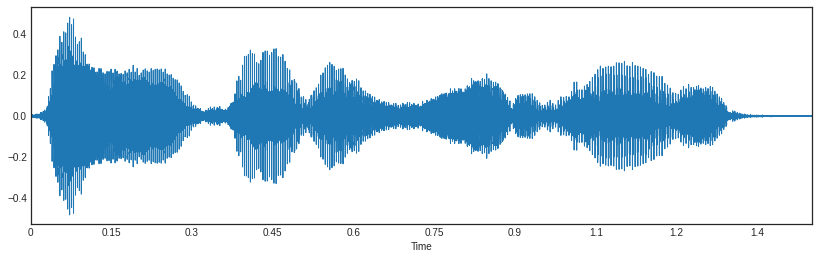

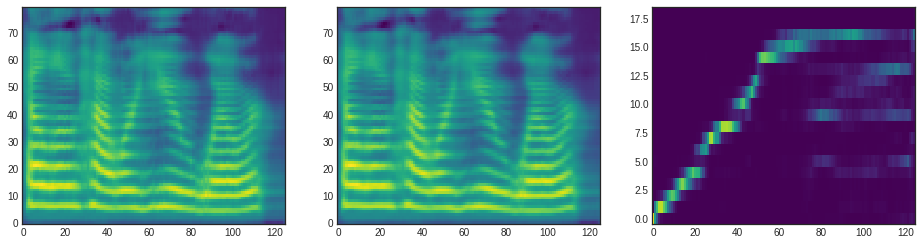

In [7]:
import librosa.display
from IPython.display import Audio

text = "Hello, how are you?"
mel_output, mel_output_postnet, aligment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14, 4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output, mel_output_postnet, aligment))
Audio(audio_np, rate=sampling_rate)

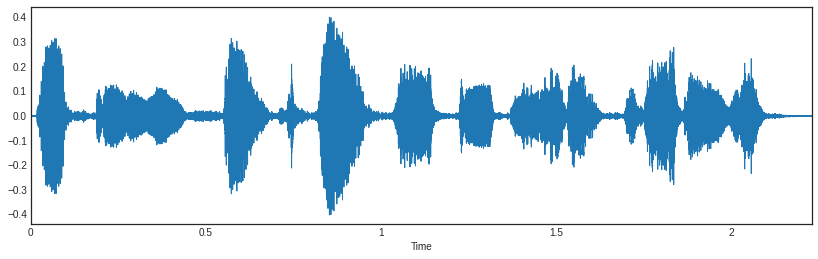

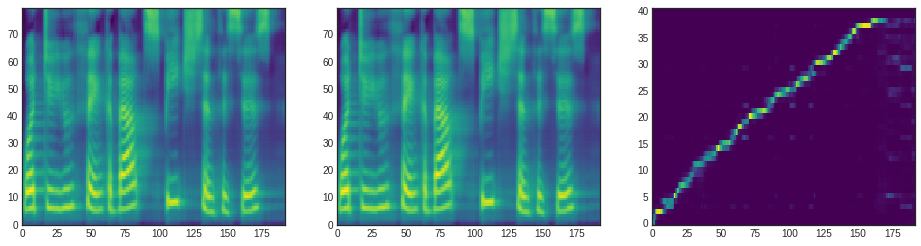

In [8]:
text = "What do you think about speech synthesis?"
mel_output, mel_output_postnet, aligment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14, 4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output, mel_output_postnet, aligment))
Audio(audio_np, rate=sampling_rate)

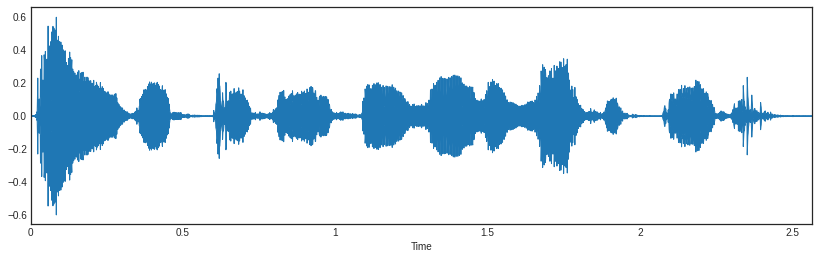

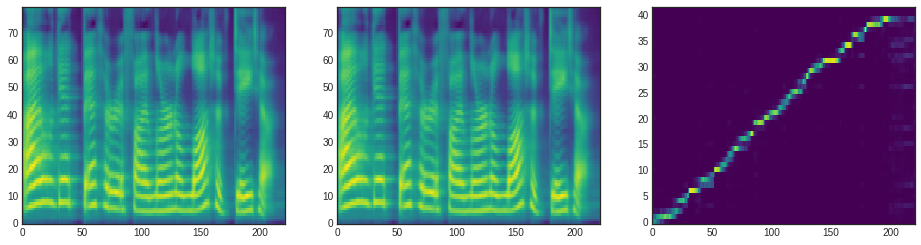

In [9]:
text = "I'll get betther if I learn a lot of data."
mel_output, mel_output_postnet, aligment, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14, 4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
plot_data((mel_output, mel_output_postnet, aligment))
Audio(audio_np, rate=sampling_rate)